In [1]:
#imports we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

sb.set_theme(style="white")

In [2]:
#import our data
df = pd.read_csv("../Data/merchants_summaries (2).csv", sep=';', decimal=',', index_col=None)
df = df.dropna()

df.head()

,period,SettlementAmountISK,NMerchantID,MerchantName,DaysSinceLastSettlement,CompanySSN,Transactions,avgTransactionsPerDay,Fees,FeeRatio,TransactionsLastTwoMonths,avgTransactionsPerDayLastTwoMonths,SettlementsLastTwoMonths,FeeRatioLastTwoMonths,MerchantBalance,MerchantActive
0,619,405606.0,8001896,Adalbilar,0.0,6005161320,44,0.186047,-2490.9604,-0.006141,12.0,0.825000,331161.5,-0.063492,0.0,1
1,619,2300708.0,8001997,BK Kjuklingur,0.0,5011032090,700,0.011445,-29101.9137,-0.012649,1094.0,0.011299,3608151.5,-0.023730,0.0,1
2,618,66685.0,8002023,Taeki.is,23.0,6503992859,2,11.000000,-733.6965,-0.011002,1.0,0.000000,51956.0,-0.016284,35685.0,1
3,619,18000.0,8002049,M Harstofa,0.0,4803190950,2,3.000000,-177.2200,-0.009846,13.0,0.500000,92200.0,-0.021834,145960.0,1
4,619,786198.0,8002055,Bílvirkinn bifreiðaverkstæði,0.0,5404201300,14,0.615385,-6926.5878,-0.008810,21.0,0.361111,1024643.0,-0.012945,-84345.0,1


In [3]:
import pickle

with open('boosted-random-forest-17-11-2020.pkl', 'rb') as f:
    classification_dict = pickle.load(f)

pred = df.drop(columns=['period', 'MerchantName', 'CompanySSN', 'NMerchantID', 'DaysSinceLastSettlement', 'MerchantActive'])
y_pred = [y_item[0] for y_item in classification_dict.predict_proba(pred)]
df['churn_proba']=y_pred
df.head()

,period,SettlementAmountISK,NMerchantID,MerchantName,DaysSinceLastSettlement,CompanySSN,Transactions,avgTransactionsPerDay,Fees,FeeRatio,TransactionsLastTwoMonths,avgTransactionsPerDayLastTwoMonths,SettlementsLastTwoMonths,FeeRatioLastTwoMonths,MerchantBalance,MerchantActive,churn_proba
0,619,405606.0,8001896,Adalbilar,0.0,6005161320,44,0.186047,-2490.9604,-0.006141,12.0,0.825000,331161.5,-0.063492,0.0,1,0.080103
1,619,2300708.0,8001997,BK Kjuklingur,0.0,5011032090,700,0.011445,-29101.9137,-0.012649,1094.0,0.011299,3608151.5,-0.023730,0.0,1,0.090856
2,618,66685.0,8002023,Taeki.is,23.0,6503992859,2,11.000000,-733.6965,-0.011002,1.0,0.000000,51956.0,-0.016284,35685.0,1,0.897919
3,619,18000.0,8002049,M Harstofa,0.0,4803190950,2,3.000000,-177.2200,-0.009846,13.0,0.500000,92200.0,-0.021834,145960.0,1,0.145034
4,619,786198.0,8002055,Bílvirkinn bifreiðaverkstæði,0.0,5404201300,14,0.615385,-6926.5878,-0.008810,21.0,0.361111,1024643.0,-0.012945,-84345.0,1,0.154787


In [4]:
from datetime import datetime

seasonalities = pd.read_csv("../Data/seasonalities.csv")
seasons = []

for mid in df.NMerchantID:
    s = seasonalities[seasonalities['MID'] == mid]
    
    if len(s) == 0:
        seasons.append(1)
    else:
        start = s['Start'].values[0]
        end = s['End'].values[0]
        month = datetime.today().month
        
        if start <= month <= end:
            seasons.append(1)
        else:
            seasons.append(0)
df['inseason'] = seasons

In [5]:
a = df[((df['MerchantActive'] == 1) & (df['churn_proba'] < 0.3)) | (df['MerchantActive'] == 0)]
df = df.drop(columns=['period', 'MerchantName', 'CompanySSN', 'NMerchantID', 'DaysSinceLastSettlement'])
df.head()

,SettlementAmountISK,Transactions,avgTransactionsPerDay,Fees,FeeRatio,TransactionsLastTwoMonths,avgTransactionsPerDayLastTwoMonths,SettlementsLastTwoMonths,FeeRatioLastTwoMonths,MerchantBalance,MerchantActive,churn_proba,inseason
0,405606.0,44,0.186047,-2490.9604,-0.006141,12.0,0.825000,331161.5,-0.063492,0.0,1,0.080103,1
1,2300708.0,700,0.011445,-29101.9137,-0.012649,1094.0,0.011299,3608151.5,-0.023730,0.0,1,0.090856,1
2,66685.0,2,11.000000,-733.6965,-0.011002,1.0,0.000000,51956.0,-0.016284,35685.0,1,0.897919,1
3,18000.0,2,3.000000,-177.2200,-0.009846,13.0,0.500000,92200.0,-0.021834,145960.0,1,0.145034,1
4,786198.0,14,0.615385,-6926.5878,-0.008810,21.0,0.361111,1024643.0,-0.012945,-84345.0,1,0.154787,1


Percantage of (1) data present: 88.59747023809523%
Percantage of (0) data present: 11.402529761904761%
Total number of rows in data:  10752


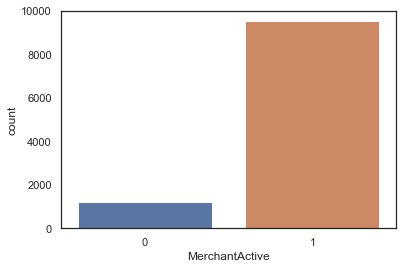

In [6]:
print("Percantage of (1) data present: {}%".format(len(df[df['MerchantActive'] == 1])/len(df['MerchantActive']) * 100))
print("Percantage of (0) data present: {}%".format(len(df[df['MerchantActive'] == 0])/len(df['MerchantActive']) * 100))
print("Total number of rows in data: ", len(df))
ax = sb.countplot(x='MerchantActive', data=df)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier # might test with decision trees and such later
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [8]:
df = df.drop(columns=['churn_proba'])

X = df.drop(['MerchantActive'], axis=1)
y = df['MerchantActive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [9]:
#random forest hyper parameter tuning
param_grid = {
    'bootstrap': [True,False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [x*10 for x in range(15)]
}

clf = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 27.4min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140]},
             verbose=2)

In [10]:
clf_rf = None
clf_rf_score = 0

for i in range(100):
    c = grid_search_rf.best_estimator_
    c.fit(X_train, y_train)
    score = c.score(X_test, y_test)

    if score > clf_rf_score:
        print("Current best: {}".format(score))
        clf_rf_score = score
        clf_rf = c
print("Max: {}".format(clf_rf_score))

Current best: 0.8888888888888888
Current best: 0.8902835890283589
Current best: 0.8907484890748489
Current best: 0.891213389121339
Current best: 0.8921431892143189
Current best: 0.893072989307299
Max: 0.893072989307299


### Adaboosted RF

In [11]:
param_grid = {
    'n_estimators': [x*10 for x in range(15)],
    'learning_rate': [0.1+(x*0.1) for x in range(15)],
    'algorithm': ['SAMME', 'SAMME.R']
}

clf = AdaBoostClassifier(base_estimator=grid_search_rf.best_estimator_)

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 450 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 91.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 267.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 301.5min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 310.5min finished


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                                                max_depth=90,
                                                                                max_features=3,
                                                                                min_samples_leaf=3,
                                                                                min_samples_split=12,
                                                                                n_estimators=130)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6, 0.7000000000000001, 0.8,
                                           0.9, 1.0, 1.1, 1.2000000000000002,
                                           1.3000000000000003,
          

In [12]:
from sklearn.ensemble import AdaBoostClassifier

clf_ada = None
clf_ada_score = 0

for i in range(100):
    c = grid_search.best_estimator_
    c.fit(X_train, y_train)
    score = c.score(X_test, y_test)

    if score > clf_ada_score:
        print("Current best: {}".format(score))
        clf_ada_score = score
        clf_ada = c
print("Max: {}".format(clf_ada_score))

Current best: 0.891213389121339
Current best: 0.8921431892143189
Current best: 0.893072989307299
Max: 0.893072989307299


### Gradient Boosting

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [x*10 for x in range(15)],
    'learning_rate': [0.1+(x*0.1) for x in range(15)],
    'subsample':[0.1*(x+1) for x in range(10)],
    'loss': ['deviance', 'exponential']
}

clf = GradientBoostingClassifier()

grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4500 candidates, totalling 13500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 824 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1293 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1838 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2565 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 3368 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 4265 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 5242 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 6301 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 7544 tasks      | elapsed: 19.7min
[Parallel(n_jobs=-1)]: Done 8845 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 10250 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 11760 tasks      

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6, 0.7000000000000001, 0.8,
                                           0.9, 1.0, 1.1, 1.2000000000000002,
                                           1.3000000000000003,
                                           1.4000000000000001,
                                           1.5000000000000002],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140],
                         'subsample': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                       0.6000000000000001, 0.7000000000000001,
                                       0.8, 0.9, 1.0]},
             verbose=2)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = None
clf_gb_score = 0

for i in range(100):
    c = grid_search.best_estimator_
    c.fit(X_train, y_train)
    score = c.score(X_test, y_test)

    if score > clf_gb_score:
        print("Current best: {}".format(score))
        clf_gb_score = score
        clf_gb = c
print("Max: {}".format(clf_gb_score))

Current best: 0.8823802882380288
Current best: 0.8833100883310089
Current best: 0.8856345885634589
Current best: 0.8860994886099489
Current best: 0.8870292887029289
Max: 0.8870292887029289


### Results

Name                          Accuracy  Precision Recall    F1        
AdaBoostClassifier            89.0      99.1      89.6      94.1      
RandomForestClassifier        88.9      99.1      89.5      94.0      
GradientBoostingClassifier    88.3      99.1      89.0      93.7      
AdaBoostClassifier


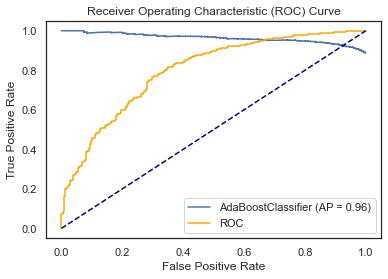

RandomForestClassifier


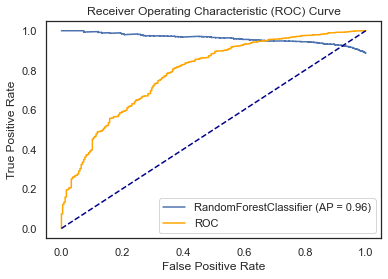

GradientBoostingClassifier


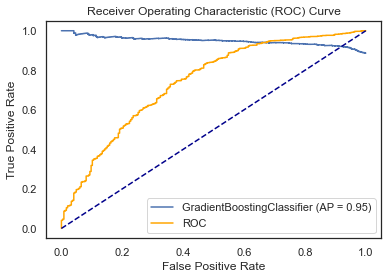

In [16]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

clfs = [clf_ada, clf_rf, clf_gb]

print("{:<30}{:<10}{:<10}{:<10}{:<10}".format("Name", "Accuracy", "Precision", "Recall", "F1"))

for c in clfs:
    y_pred = c.predict(X_test)
    accuracy = accuracy_score(y_pred,y_test)
    f1 = f1_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    
    print("{:<30}{:<10.1f}{:<10.1f}{:<10.1f}{:<10.1f}".format(c.__class__.__name__, accuracy*100, precision*100, recall*100, f1*100))

for c in clfs:
    print(c.__class__.__name__)
    y_pred = c.predict(X_test)
    disp = plot_precision_recall_curve(c, X_test, y_test)


    average_precision = average_precision_score(y_test, y_pred)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))
    
    y_pred = c.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plot_roc_curve(fpr, tpr)